In [1]:
from typing import List

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.animation as animation
import time
import struct
import tensorflow as tf
import random as rd

from math import *
from array import array

# import keras._tf_keras.keras as keras 
# from keras._tf_keras.keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from tensorflow.python.ops.init_ops_v2 import glorot_uniform

# my project
from module.conf import PROJECT_DIR

# matplotlib.use("QTAgg")
%matplotlib inline

Load data:
- Train data: 60k 28x28 images
- Test data: 

In [2]:
mnist_path = "/data/sample/mnist"
training_images_filepath = "".join([PROJECT_DIR, mnist_path, "/train-images.idx3-ubyte"])
training_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/train-labels.idx1-ubyte"])
test_images_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-images.idx3-ubyte"])
test_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-labels.idx1-ubyte"])

def read_images_labels(images_filepath, labels_filepath) -> tuple:
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        # labels = array("B", file.read())
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())       
     
    images = []
    # for i in range(size):
    #     images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        # images[i][:] = img
        images.append(img)
    
    return images, labels

def load_data() -> tuple:
    x_train, y_train = read_images_labels(training_images_filepath, training_labels_filepath)
    x_test, y_test = read_images_labels(test_images_filepath, test_labels_filepath)
    return (x_train, y_train),(x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

In [3]:
# print(f"{type(X_train[0])}")
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()


In [4]:
X_train = np.asarray(X_train) / 255
y_train = np.asarray(y_train)
X_test  = np.asarray(X_test) / 255
y_test  = np.asarray(y_test)

## 1. Activation functions:

### 1.1. Linear:
$ \begin{align}
f(\mathbf z) &= \mathbf z \\
\rightarrow \frac{\partial f(\mathbf z)}{\partial \mathbf z} &=\mathbf 1 \\ 
\end{align} $

In [5]:
def linear(z): return z
def grad_linear(z): return 1

### 1.2. ReLU:
$\begin{align}
ReLU(\mathbf z) &= \max(\mathbf z, \mathbf 0) \\
\rightarrow \frac{\partial ReLU(\mathbf z)}{\partial \mathbf z} &= \begin{cases}
z_i = 1 \text{ if } z_i > 0 \\
z_i = 0 \text{ if } z_i \leqslant 0 \\
\end{cases} \\
\end{align}$

In [6]:
def relu(z): return np.maximum(0, z)
def grad_relu(z): return np.where(z > 0, 1, 0) # (x > 0).astype(float) # np.array([1 if z_i > 0 else 0 for z_i in z])

In [7]:
z = np.array([1,-6, 3, 4, 0])
relu_z = relu(z)
relu_z
grad_relu_z = grad_relu(relu_z)
grad_relu_z

array([1, 0, 1, 1, 0])

### 1.2. Sigmoid:
$\begin{align}
\sigma(\mathbf z) &= \frac{1}{1 + e^{-z}} \\
\rightarrow \frac{\partial\sigma(\mathbf z)}{\partial \mathbf z} &= \sigma(\mathbf z)\cdot\left(1 - \sigma(\mathbf z)\right) \\ 
\end{align} $

In [8]:
def sigmoid(z): return 1/(1 + np.exp(-z))
def grad_sigmoid(z): return sigmoid(z) * (1 - sigmoid(z))    

In [9]:
z = np.array([1,-6, 3, 4, 0])
sigmoid(z)
grad_sigmoid(z)

array([0.19661193, 0.00246651, 0.04517666, 0.01766271, 0.25      ])

### 1.3. Softmax:
$\begin{align}
\sigma(\mathbf z) &= \frac{e^{\mathbf z}}{\sum_{i=1}^{C}e^{z_i}} \\
\rightarrow \frac{\partial \sigma(\mathbf z)}{\partial \mathbf z} &= \sigma(z_i) \cdot (\delta_{ij} - \sigma(z_j)) 
\rightarrow \delta_{ij} = \begin{cases} 
1 \text{ if } i = j \\
0 \text{ if } i \neq j  
\end{cases} \\
&= diag(\mathbf z) - \mathbf z * \mathbf z^T \\
C &\text{ is number of class} \\
diag &\text{ is diagonal matrix }
\end{align}$

In [10]:
# def softmax(z): return np.exp(z)/np.sum(np.exp(z))
# def grad_softmax(z): return np.diag(z) - np.outer(z,z)
def softmax(Z):
    Z_max = np.max(Z, axis=0, keepdims=True)
    Z_exp = np.exp(Z - Z_max)
    Z_sum = np.sum(Z_exp, axis=0, keepdims=True)
    return Z_exp / Z_sum
    # e_x = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    # return e_x / np.sum(e_x, axis=-1, keepdims=True)

def grad_softmax(Z):
    S = softmax(Z)  # Tính softmax cho Z
    batch_size, num_classes = S.shape
    # Init Jacobian matrix: gradient foreach row
    dSoftmax = np.zeros((batch_size, num_classes, num_classes))
    for i in range(batch_size):
        # S_i is softmax for i-row
        s_i = S[i].reshape(-1, 1)  # Transpose to Column vector
        # Jacobian matrix for i-row
        # dSoftmax[i] = np.diagflat(s_i) - np.dot(s_i, s_i.T)
        dSoftmax[i] = np.diagflat(s_i) - s_i @ s_i.T
    # dSoftmax in hidden layer - transpose of Jacobian matrix    
    return dSoftmax.transpose()

In [11]:
z = np.array([[1,-6, 3, 4, 0],
              [1,-6, 3, 7, 0]])
# softmax(z)
z_max = np.max(z, axis=z.ndim-1, keepdims=True)
z_max
# np.exp(z-z_max)
# grad_softmax(z)

array([[4],
       [7]])

## 2. Loss function:

### 2.1. Cross Entropy:
$\begin{align}
CrossEntropy = - \log(\hat{y}_{true})\\
\end{align}$

### 2.2. Categorical Crossentropy:
$\begin{align}
Y &\text{ is label in one-hot matrix } N \times C  \\
\hat{Y} &\text{ is predicted matrix } N \times C \\
C &\text{ is number of classes}\\
L &= -\sum_{i=1}^{C} Y_i \log(\hat{Y}_{i}) \\
\hat{Y}_{i,j} &= \frac{exp(Z_{i,j})}{\sum_{k=1}^{C} exp(Z_{i,k})} \\
\rightarrow \mathcal L &= -\frac{1}{N} \sum_{i=1}^{N}\sum_{j=1}^{C} Y_{i,j} \log(\hat{Y}_{i,j}) \\
&= -\frac{1}{N} \sum_{i=1}^{N} \log(\hat{Y}_{i,true}) \\
\hat{Y}_{i,true} &\text{ is predicted result corresponding to one-hot is 1}
\end{align}$

Gradient:
$\begin{align}
\frac{\partial L}{\partial Z} &= \hat{Y}_{i,j} - Y_{i,j} \\
\end{align}$

### 2.3. Sparse Categorical Crossentropy:
$ \begin{align}
\hat{Y} &= A_n = softmax(Z) \\
Z &\text{ is } n \times C \text{ matrix. n is number of samples, C is number of classes} \\
CrossEntropy_i &= -\log(\hat{y}_{i, y_{sparse}}) \\
CrossEntropy &\text{ is a vector size n} \\
\rightarrow \frac{\partial L}{\partial Z_{i,j}} &= \hat{Y}_{i,j} - \delta(j, y_{sparse,i}) 
\rightarrow \delta(j, y_{sparse,i}) = \begin{cases}
1 \text{ if } j = y_{sparse,i} \\
0 \text{ if } j \neq y_{sparse,i}\\
\end{cases} \\
\rightarrow \frac{\partial L}{\partial Z_n} &= \hat{Y} - Y = \hat{Y} - SparseLabels \\
SparseLabels &\text{ can be considered as one-hot matrix}
\end{align} $

In [12]:
# should apply the Vectorization
def delta_kronecker_matrix(y_train, mY_pred):
    """
    Transform to one-hot encoding
    y_train: a vector size n
    mY_pred: a matrix (C, n)
    """
    mY_train = np.zeros(shape=mY_pred.T.shape)
    for i in range(len(y_train)): mY_train[i][y_train[i]] = 1
    return mY_train

def sparse_categorical_crossentropy_Z(y_train, mY_pred):
    y_pred = np.array([mY_pred[i][y_train[i]] for i in range(len(y_train))])
    return -np.sum(np.log(y_pred))

def grad_sparse_categorical_crossentropy_Z(y_train, mY_pred):
    return mY_pred - delta_kronecker_matrix(y_train=y_train, mY_pred=mY_pred)

def sparse_categorical_crossentropy(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true_indices = (y_true, np.arange(batch_size))
    correct_class_probabilities = y_pred[y_true_indices]
    loss = -np.log(correct_class_probabilities + 1e-7).mean()
    return loss

def grad_sparse_categorical_crossentropy(y_true, y_pred):
    # Grad
    grad = np.zeros_like(y_pred)
    grad[:y_pred.shape[0], y_true] = -1 / y_pred[:y_pred.shape[0], y_true]  # Grad for true-class
    return grad

In [13]:
import numpy as np
from scipy.sparse import csr_matrix
# ex
# [[0, 0, 0, 0],
#  [5, 8, 0, 0],
#  [0, 0, 3, 0],
#  [0, 6, 0, 0]]
#

data = np.array([5, 8, 3, 6, 7])        # values
indices = np.array([0, 1, 2, 1, 0])     # col index for each value
indptr = np.array([0, 2, 3, 4, 5])      # start - end in data values
csr_m = csr_matrix((data, indices, indptr), shape=(4, 4))
csr_m.toarray()


array([[5, 8, 0, 0],
       [0, 0, 3, 0],
       [0, 6, 0, 0],
       [7, 0, 0, 0]])

## 3. Optimizers: 

In [14]:
def optimize_basicGD(w:np.ndarray, b:np.ndarray, grad_w: np.ndarray, grad_b: np.ndarray, learning_rate=1e-2):
    w -= learning_rate * grad_w
    b -= learning_rate * grad_b
    return w, b

### 3.1. SGD
$\begin{align}
\theta &= \theta - \eta \cdot \nabla_{\theta} L(\theta, x_i, y_i) \\
\theta &\text{ is weight}\\
\eta &\text{ is learning rate}\\
\nabla_{\theta} L(\theta, x_i, y_i) &\text{ is gradient respect to }\theta \text{ of }(x_i, y_i) \\
\end{align}$

### 3.2. RMSProps:
$\begin{align}
v_{t} &= \beta v_{t-1} + (1 - \beta)g_t^2 \\
\\
\theta_t &= \theta_{t-1} - \frac{\eta}{\sqrt{v_t} + \epsilon} g_t \\
\eta &\text{ is learning rate} \\
v_t &\text{ is velocity at } t \text{ time} \\
g_t &\text{ is gradient at } t \text{ time} \\
\epsilon &\text{ is very small number - avoid device by 0} \\
\theta &\text{ is weight matrix or bias vector} \\
\end{align}$

In [15]:
def optimize_RMSProps(w: np.ndarray, b: np.ndarray, grad_w: np.ndarray, grad_b: np.ndarray, v_w:np.ndarray=None, v_b:np.ndarray=None,
                      learning_rate=0.01, beta=0.9, epsilon=1e-7):
    # if v_w is None: v_w = np.zeros_like(w)
    # if v_b is None: v_b = np.zeros_like(b)
    v_w = beta * v_w + (1 - beta) * grad_w ** 2
    v_b = beta * v_b + (1 - beta) * grad_b ** 2
    # print(f"v_w: {v_w.shape} v_b: {v_b.shape}")
    w -= learning_rate * grad_w / (np.sqrt(v_w) + epsilon)
    b -= learning_rate * grad_b / (np.sqrt(v_b) + epsilon)
    return w, b, v_w, v_b

def optimize_RMSPropsL1(w: np.ndarray, b: np.ndarray, grad_w: np.ndarray, grad_b: np.ndarray, v_w:np.ndarray=None, v_b:np.ndarray=None,
                      learning_rate=0.01, beta=0.9, epsilon=1e-7, lambda_l1 = 1e-2, loss=0.0):
    # l1_loss = lambda_l1 * np.sum(np.abs(w))
    l1_loss = lambda_l1 * np.sum(w**2)
    loss += l1_loss
    grad_w += lambda_l1 * np.sign(w)
    # grad_b += lambda_l1 * np.sign(b)
    v_w = beta * v_w + (1 - beta) * grad_w ** 2
    v_b = beta * v_b + (1 - beta) * grad_b ** 2
    # print(f"v_w: {v_w.shape} v_b: {v_b.shape}")
    w -= learning_rate * grad_w / (np.sqrt(v_w) + epsilon)
    b -= learning_rate * grad_b / (np.sqrt(v_b) + epsilon)
    return w, b, v_w, v_b, loss + l1_loss

### 3.3. Adagrad
$\begin{align}
G_t &= G_{t-1} + g_t^2 \\
\theta_t &= \theta_{t-1} - \frac{\eta}{\sqrt{G_t - \epsilon}} \cdot g_t \\
\eta &\text{ is learning rate} \\
g_t &\text{ is gradient at } t \text{ time} \\
\epsilon &\text{ is very small number - avoid device by 0} \\
\theta &\text{ is weight matrix or bias vector} \\
G &\text{ sum of square of gradient} \\
\end{align}$

### 3.4. Adaprops:

### 3.5. Adamax:

### 3.6.Adam: 
$\begin{align}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat m_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat v_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} \\
g_t &\text{ is gradient at } t \text{ time} \\
\epsilon &\text{ is very small number - avoid device by 0} \\
\theta &\text{ is weight matrix or bias vector} \\
G &\text{ sum of square of gradient} \\
\end{align}$

### 5. Demo NN


### 5.1. Load/Prepare data

### 5.2. Neural network manually:
- Flat 28 x 28 data
- There are 03 layers: `[32, "relu"] [128, "sigmoid"] [10, "softmax"]`
- Loss func: `SparseCategoricalCrossentropy`, `digits = False`
- Optimizer: `RMSProp` with `learning_rate=1e-3`
- **(opt)** metrics: `accuracy`

### 5.3. Flat input data:

In [16]:
def flat_data(imp_data: np.ndarray) -> np.ndarray:
    """
    Flat data from 02 dim matrix to vector
    :param imp_data: (n, m_0, m_1) matrix, n is number of rows 
    :return: matrix: (n, m_0 * m_1)
    """
    # scaler = MinMaxScaler(feature_range=(0, 1)) --> better accuracy, faster convergence
    # scaler = StandardScaler(with_mean=True, with_std=True) --> better accuracy, faster convergence
    scaler = StandardScaler(with_mean=False, with_std=False) # dont substract mean, dont devide by std ~ X, not scale
    if len(imp_data.shape) < 3 : return scaler.fit_transform(imp_data)
    return scaler.fit_transform(imp_data.reshape((-1, imp_data.shape[1] * imp_data.shape[2])).T).T

### 5.4. Loop

In [17]:
class DenseLayer (object):
    activation_map = {"linear": linear, "relu": relu, "sigmoid": sigmoid, "softmax": softmax}
    grad_map = {"linear": grad_linear, "relu": grad_relu, "sigmoid": grad_sigmoid, "softmax": grad_softmax}

    def glorot_normal(self, shape, n_in, n_out):
        stddev = np.sqrt(2 / (n_in + n_out))
        return np.random.normal(loc=0, scale=stddev, size=shape)

    def glorot_uniform(self, shape, n_in, n_out):
        limit = np.sqrt(6 / (n_in + n_out))
        return np.random.uniform(low=-limit, high=limit, size=shape)

    def __init__(self, input_size, output_size, activation = 'linear'):
        self._activation_func = self.activation_map['linear']
        self._grad_func = self.grad_map['linear']
        self._activation = activation.lower()
        # self._weights = np.random.rand(output_size, input_size) * 1e-2
        # self._weights = np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)
        self._weights = self.glorot_uniform(shape=(output_size, input_size), n_in=input_size, n_out=output_size)
        # self._bias = np.random.rand(output_size, 1)
        # self._bias = np.random.randn(output_size, 1) * np.sqrt(2 / input_size)
        self._bias = np.zeros(shape=(output_size, 1))
        self._cache_w = [np.zeros_like(self._weights), np.zeros_like(self._weights)]
        self._cache_b = [np.zeros_like(self._bias), np.zeros_like(self._bias)]
        self._init()
        return
    
    def _init(self) -> None:
        self._activation_func = DenseLayer.activation_map[self._activation] if self._activation in DenseLayer.activation_map else DenseLayer.activation_map['linear']
        self._grad_func = DenseLayer.grad_map[self._activation] if self._activation in DenseLayer.grad_map else DenseLayer.grad_map['linear']
        return None

    @property
    def activation_func(self):
        return self._activation_func
    @property
    def grad_func(self):
        return self._grad_func

    @property
    def weights(self) -> np.ndarray:
        return self._weights
    @weights.setter
    def weights(self, val):
        self._weights = val
    @property
    def bias(self) -> np.ndarray:
        return self._bias
    @bias.setter
    def bias(self, val):
        self._bias = val

    @property
    def cache_w(self):
        return self._cache_w
    @cache_w.setter
    def cache_w(self, val):
        self._cache_w = val
    @property
    def cache_b(self):
        return self._cache_b
    @cache_b.setter
    def cache_b(self, val):
        self._cache_b = val

    pass

In [18]:
class NNClassification(object):
    """
    Layers:
    - (units=32, activation=tf.keras.activations.relu),
    - (units=128, activation=tf.keras.activations.relu),
    - (units=10, activation=tf.keras.activations.linear)
    Loss: softmax + SparseCategoricalCrossEntropy
    Optimizer: Adam
    """
    def __init__(self, input_size: int, output_size: int, learning_rate=1e-3, lambda_ = 1e-3):
        self.Z = []
        self.A = []
        self.learning_rate = learning_rate
        self.lambda_ = lambda_
        self.layers: list[DenseLayer] = [None, # dont count
            DenseLayer(input_size=input_size, output_size=128, activation='relu'),
            DenseLayer(input_size=128, output_size=64, activation='relu'),
            DenseLayer(input_size=64, output_size=10, activation='softmax')]
        # - (units=32, activation=tf.keras.activations.relu),
        # - (units=128, activation=tf.keras.activations.relu),
        # - (units=10, activation=tf.keras.activations.linear)
        return
    
    def glorot_normal(self, shape, n_in, n_out):
        stddev = np.sqrt(2 / (n_in + n_out))
        return np.random.normal(loc=0, scale=stddev, size=shape)

    def glorot_uniform(self, shape, n_in, n_out):
        limit = np.sqrt(6 / (n_in + n_out))
        return np.random.uniform(low=-limit, high=limit, size=shape)

    def linear(self, x): return x

    def relu(self, x): return np.maximum(0, x)

    def grad_relu(self, x): return np.where(x > 0, 1, 0) #return x > 0

    def softmax(self, x):
        x_max = np.max(x, axis=-1, keepdims=True)
        x_exp = np.exp(x - x_max)
        x_sum = np.sum(x_exp, axis=-1, keepdims=True)
        return x_exp / x_sum

    def optimize_Adam(self, w: np.ndarray, b: np.ndarray, grad_w: np.ndarray, grad_b: np.ndarray,
                      cache_w: list[np.ndarray], cache_b:list[np.ndarray],
                      learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        if cache_w is None: cache_w = [np.zeros_like(w), np.zeros_like(w)]
        if cache_b is None: cache_b = [np.zeros_like(b), np.zeros_like(b)]
        grad_w += self.lambda_ * w
        cache_w[1] = beta1 * cache_w[1] + (1 - beta1) * grad_w
        cache_b[1] = beta1 * cache_b[1] + (1 - beta1) * grad_b
        cache_w[0] = beta2 * cache_w[0] + (1 - beta2) * grad_w ** 2
        cache_b[0] = beta2 * cache_b[0] + (1 - beta2) * grad_b ** 2
        m_w_hat = cache_w[1] / (1 - beta1)
        m_b_hat = cache_b[1] / (1 - beta1)
        v_w_hat = cache_w[0] / (1 - beta2)
        v_b_hat = cache_b[0] / (1 - beta2)
        updated_w = w - learning_rate * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
        updated_b = b - learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)
        return updated_w, updated_b, cache_w, cache_b

    def compute_loss(self, y_true: np.ndarray, y_pred: np.ndarray):
        samples = y_true.shape[0]
        correct_logprobs = -np.log(y_pred[y_true, range(samples)])
        return np.mean(correct_logprobs) + self.lambda_/(2*samples) * np.sum(np.square(self.layers[-1].weights))
    
    def forward_propagate(self, epoch, X) -> np.ndarray:
        """
        forward propagation
        :param X: (n, m) training data 
        :return: last value
        """
        self.A.clear()
        self.Z.clear()
        self.A.append(X)
        self.Z.append(None)
        
        for idx in range(1, len(self.layers)):
            layer = self.layers[idx]
            tmp_z = layer.weights @ self.A[idx - 1] + layer.bias
            tmp_a = layer.activation_func(tmp_z)
            self.Z.append(tmp_z)
            self.A.append(tmp_a)
            pass
        return self.A[-1]
    
    def backward_propagate(self, epoch, y) -> np.ndarray:
        """
        backward propagation
        :param X: (n, m) n features, m samples
        :param y: (n) labels
        :return:
        """
        dA = [None] * len(self.layers)
        dZ = [None] * len(self.layers)
        dW = [None] * len(self.layers)
        db = [None] * len(self.layers)
        
        no_of_samples = y.shape[0] # X.shape[1]
        
        # calculate dL/dZ[-1] = y_pred - y = A[-1] - y
        dZ[-1] = self.A[-1]
        dZ[-1][y, range(no_of_samples)] -= 1
        dZ[-1] /= no_of_samples
        
        # dW[-1] = dL/dZ[-1] @ dZ[-1]/dW[-1] = dZ[-1] @ A[-2]
        dW[-1] = dZ[-1] @ self.A[-2].T
        db[-1] = np.sum(dZ[-1], axis=1, keepdims=True) # dZ[-1] @ np.ones((dZ[-1].shape[1], 1))
        dWb = [None] * len(self.layers)
        dWb[-1] = (dW[-1], db[-1])
        for idx in range(len(self.layers) - 2, 0, -1):
            layer = self.layers[idx]
            # calculate dA, dZ, dW, db
            dA[idx] = self.layers[idx + 1].weights.T @ dZ[idx + 1]
            dZ[idx] = dA[idx] * layer.grad_func(self.Z[idx])
            dW[idx] = dZ[idx] @ self.A[idx - 1].T
            db[idx] = np.sum(dZ[idx], axis=1, keepdims=True)
            dWb[idx]= (dW[idx], db[idx])
            pass
        return dWb
    
    def update_weights(self, dWb: np.ndarray, no_of_samples: int) -> None:
        if dWb is None: return
        for idx, (layer, dWb_itm) in enumerate(zip(self.layers[1:], dWb[1:])):
            #     layer = self.layers[idx]
            # layer.weights, layer.bias, layer.cache_w, layer.cache_b = self.optimize_Adam(
            #     w=layer.weights, b=layer.bias,
            #     grad_w=dWb[idx][0], grad_b=dWb[idx][1],
            #     cache_w=layer.cache_w, cache_b=layer.cache_b,
            #     learning_rate=self.learning_rate, beta1=0.9, beta2=0.999)
            
            layer.weights, layer.bias, layer.cache_w, layer.cache_b = self.optimize_Adam(
                w=layer.weights, b=layer.bias,
                grad_w=dWb_itm[0], grad_b=dWb_itm[1],
                cache_w=layer.cache_w, cache_b=layer.cache_b,
                learning_rate=self.learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-7)
            pass
        return
    
    def fit(self, X: np.ndarray, Y: np.ndarray, epochs: int=1, batch_size: int=32, min_delta:float = -1) -> None:
        """
        
        :param X_train: matrix(n, m) n - features, m - number of samples
        :param Y_train: vector(n), - labels in sparse
        :param epochs: epochs
        :param batch_size:
        :param min_delta:
        :return: list of weight matrix, from 0
        """
        # read and normalize data
        noOfSamples = X.shape[1]
        loss = 0.0
        accuracy = 0.0
        for epoch in range(epochs):
            permu = np.random.permutation(noOfSamples)
            X_shuffled = X[:, permu]
            Y_shuffled = Y[permu]
            last_loss = loss
            last_accuracy = accuracy
            for idx in range(0, noOfSamples, batch_size):
                X_batch = X_shuffled[:, idx:idx + batch_size]
                Y_batch = Y_shuffled[idx:idx + batch_size]
                # forward
                Y_pred = self.forward_propagate(epoch, X_batch)
                # calculate cost and accuracy
                # last_accuracy = accuracy
                loss = self.compute_loss(Y_batch, Y_pred)
                accuracy = accuracy_score(Y_batch, np.argmax(Y_pred, axis=0, keepdims=False))
                # backward
                dWb = self.backward_propagate(epoch, Y_batch)
                # update weight
                self.update_weights(dWb, X_batch.shape[1])
            # print result
            if np.abs(accuracy) > 1 - min_delta:
                print(f"Epochs[{epoch+1}] Loss: {loss:4f} - Accuracy: {accuracy:6f}, Prev Accuracy: {last_accuracy:6f}")
                return
            if (epoch + 1) % 1 == 0:
                print(f"Epochs[{epoch+1}] Loss: {loss:4f} - Accuracy: {accuracy:6f}")
                pass
            pass
        return

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        
        :param X: (n, m) n features, m samples 
        :return: (n) y_pred
        """
        return self.forward_propagate(0, X)

    def evaluate(self, X_test, Y_test):
        """
        :param X_test: matrix(n, m) n - number of features, m - number of samples
        :param Y_test: vector(n), labels in sparse
        :return: [lost, accuracy] 
        """
        Y_pred = self.predict(X_test)
        loss = self.compute_loss(Y_test, Y_pred)
        accuracy = accuracy_score(Y_test, np.argmax(Y_pred, axis=0, keepdims=False))
        return loss, accuracy
    
    pass

In [19]:
# split the train data
X_train_20 = train_test_split(X_train, test_size=0.2, random_state=42)[1]
Y_train_20 = train_test_split(y_train, test_size=0.2, random_state=42)[1]

len(X_train_20)
X_train_20.shape

(12000, 28, 28)

In [20]:
train_X = flat_data(X_train_20).T
n = train_X.shape[0]
m = train_X.shape[1]
nn = NNClassification(input_size=n, output_size=10, learning_rate=1e-3)
# rs1 = nn.fit(train_X, Y_train_20, epochs=50, batch_size=64, min_delta=1e-3)
nn.fit(train_X, Y_train_20, epochs=50, batch_size=m)

Epochs[1] Loss: 2.407372 - Accuracy: 0.096167
Epochs[2] Loss: 2.270193 - Accuracy: 0.168333
Epochs[3] Loss: 2.134895 - Accuracy: 0.331667
Epochs[4] Loss: 2.005205 - Accuracy: 0.496417
Epochs[5] Loss: 1.865669 - Accuracy: 0.580917
Epochs[6] Loss: 1.711652 - Accuracy: 0.627750
Epochs[7] Loss: 1.546908 - Accuracy: 0.675833
Epochs[8] Loss: 1.380574 - Accuracy: 0.705583
Epochs[9] Loss: 1.220956 - Accuracy: 0.733667
Epochs[10] Loss: 1.072214 - Accuracy: 0.764083
Epochs[11] Loss: 0.938053 - Accuracy: 0.795250
Epochs[12] Loss: 0.825166 - Accuracy: 0.816083
Epochs[13] Loss: 0.735680 - Accuracy: 0.826500
Epochs[14] Loss: 0.662328 - Accuracy: 0.834583
Epochs[15] Loss: 0.599693 - Accuracy: 0.844333
Epochs[16] Loss: 0.550133 - Accuracy: 0.851250
Epochs[17] Loss: 0.512432 - Accuracy: 0.857750
Epochs[18] Loss: 0.481503 - Accuracy: 0.864333
Epochs[19] Loss: 0.454767 - Accuracy: 0.872000
Epochs[20] Loss: 0.431135 - Accuracy: 0.878667
Epochs[21] Loss: 0.412042 - Accuracy: 0.882750
Epochs[22] Loss: 0.396

In [21]:
# split the train data
rand_seed = np.random.randint(low=0, high=1000)
X_test_20 = train_test_split(X_train, test_size=0.1, random_state=rand_seed)[1]
Y_test_20 = train_test_split(y_train, test_size=0.1, random_state=rand_seed)[1]

In [22]:
nn.evaluate(flat_data(X_test_20).T, Y_test_20)

(0.25661975374959756, 0.9228333333333333)

\begin{align}
\frac{\partial \mathcal{L} }{ \partial W^{[2]} } &= 
\frac{1}{m}\left(A^{[2]}-Y\right)\left(A^{[1]}\right)^T,\\
\frac{\partial \mathcal{L} }{ \partial b^{[2]} } &= 
\frac{1}{m}\left(A^{[2]}-Y\right)\mathbf{1},\\
\frac{\partial \mathcal{L} }{ \partial W^{[1]}} &= \frac{1}{m}\left(\left(W^{[2]}\right)^T \left(A^{[2]} - Y\right)\cdot \left(A^{[1]}\cdot\left(1-A^{[1]}\right)\right)\right)X^T,\\
\frac{\partial \mathcal{L} }{ \partial b^{[1]}} &= \frac{1}{m}\left(\left(W^{[2]}\right)^T \left(A^{[2]} - Y\right)\cdot \left(A^{[1]}\cdot\left(1-A^{[1]}\right)\right)\right)\mathbf{1},\\
\tag{15}
\end{align}

In [23]:
# Sample
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Flatten(input_shape=(28, 28,)),
    tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu),
    # tf.keras.layers.Dropout(rate=0.2),
    # tf.keras.layers.Dense(units=10, activation=tf.keras.activations.linear)
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), #tf.keras.optimizers.RMSprop(learning_rate=1e-3),
#               loss=loss_fn,
#               metrics=["accuracy"])
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), #tf.keras.optimizers.RMSprop(learning_rate=1e-3),
#               loss=loss_fn,
#               metrics=["accuracy"])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=loss_fn,
              metrics=["accuracy"])

In [24]:
#
# model.fit(x=X_train_20, y=Y_train_20, epochs=50, batch_size=32, workers=8, use_multiprocessing=True)
model.fit(x=X_train_20, y=Y_train_20, epochs=50, batch_size=X_train_20.shape[0], workers=8, use_multiprocessing=True)

Epoch 1/50


2024-10-15 23:46:15.988569: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 230ms/step - loss: 2.3868 - accuracy: 0.0887
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 2.2458 - accuracy: 0.1262
Epoch 3/50
1/1 [==============================] - 0s 21ms/step - loss: 2.1356 - accuracy: 0.2546
Epoch 4/50
1/1 [==============================] - 0s 22ms/step - loss: 2.0373 - accuracy: 0.3998
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 1.9414 - accuracy: 0.5003
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 1.8443 - accuracy: 0.5665
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 1.7462 - accuracy: 0.6086
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 1.6484 - accuracy: 0.6374
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 1.5516 - accuracy: 0.6544
Epoch 10/50
1/1 [==============================] - 0s 22ms/step - loss: 1.4560 - accuracy: 0.6761
Epoch 11/50
1/1 [======================

In [25]:
rs3 = model.evaluate(X_test_20, Y_test_20, verbose=0)
rs3  # [lost, accuracy]

[0.30647942423820496, 0.9079999923706055]

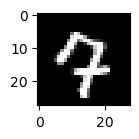

In [26]:
def show_image(img_data: np.ndarray) -> tuple:
    fig, axes = plt.subplots(figsize=(1.60, 1.20))
    axes.imshow(X=img_data, cmap="gray")
    return fig, axes

# print(y_test[5854])
# show_image(X_test[4823])
fig, axes = show_image(X_test[5854])
plt.show()

In [27]:
test_sample = flat_data(X_test[1200:1201]).T
# print(X_test[1200:1201].reshape((-1, X_test[1200:1201].shape[1] * X_test[1200:1201].shape[2])))
# print(test_sample.T)
nnpredict = nn.predict(test_sample)
nnpred = np.argmax(nnpredict, axis=0)
print(nnpred)

test_sample = flat_data(X_test[1203:1204]).T
# print(test_sample.T)
nnpredict = nn.predict(test_sample)
nnpred = np.argmax(nnpredict, axis=0, keepdims=False)
print(nnpred)
# print(f"{nn.predict(flat_data(X_test[1000:1001]).T).T} \n {nn.predict(flat_data(X_test[1000:1001]).T).T}")

# nn.evaluate(flat_data(X_test_20).T, Y_test_20)
# print(f"{nn.predict(flat_data(X_test[1000:1001]).T).T} \n {nn.predict(flat_data(X_test[1000:1001]).T).T}")

# nn.evaluate(flat_data(X_test_20).T, Y_test_20)

[3]
[0]


In [28]:
tfpredict = model.predict(X_test[1200:1201], verbose=0)
tfpred = np.argmax(tfpredict, axis=1, keepdims=False)
print(tfpred)

tfpredict = model.predict(X_test[1203:1204], verbose=0)
tfpred = np.argmax(tfpredict, axis=1, keepdims=False)
print(tfpred)

[3]
[0]


In [32]:
# np.array([y_test[1201]])
nn.evaluate(flat_data(X_test[1201:1301]).T, np.array(y_test[1201:1301]))

(0.5420430845133548, 0.82)

In [33]:
model.evaluate(X_test[1201:1301], y_test[1201:1301], verbose=0)

[0.6572191119194031, 0.7799999713897705]

### 5.2. Linear and Activation Function:

### 5.3. Loss/Cost Function

### 5.4. Optimizer

In [31]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

Num GPUs Available:  0
